# Kickstarter Project

# Business Understanding

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import copy
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Image
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [179]:
#tabelle = pd.read_excel('List_features_EDA.xlsx', sheet_name = 'Jupyter', na_values = ['.','*'])

In [180]:
#from IPython.display import Image
#Image ('Schwein_ks.jpg')

## Einlesen der csv-Datei

In [181]:
# Einlesen der csv-Datei

import glob
import pandas as pd
# get data file names
path =r'/Users/brittarover/nf-sep-2020/Projekt_2/data'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
       dfs.append(pd.read_csv(filename))
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Data Cleaning

## Check for nullvalues
The check shows that the following features: friends, is_backing, is_starred and permissions can be dropped due to missing data issue.

In [182]:
# checking null values
nan = pd.DataFrame(df.isnull().sum(),columns=['Count'])
nan['Percentage'] = round(nan.Count/df.shape[0]*100,1)
print(nan[nan.Count!=0])

              Count  Percentage
blurb             8         0.0
friends      208922        99.9
is_backing   208922        99.9
is_starred   208922        99.9
location        226         0.1
permissions  208922        99.9
usd_type        480         0.2


## Check for duplicates
No relevant duplicate.

In [183]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## Check and change of the datatypes

### Datetime Issues
We change the features deadline and launched_at and create a new feature duration later. The dates created_at and state_changed_at are dropped.

#### Feature deadline

In [184]:
# change Date-times deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [185]:
# split date to year and month and delete deadline later 
df['year_deadline'] = df['deadline'].dt.year 
df['month_deadline'] = df['deadline'].dt.month 
df['day_deadline'] = df['deadline'].dt.day
df['time_deadline'] = df['deadline'].dt.time

#### Feature launched_at

In [186]:
# change Date-times launched_at
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

In [187]:
# split date to year and month and delete deadline later 
df['year_launched'] = df['launched_at'].dt.year 
df['month_launched'] = df['launched_at'].dt.month 
df['day_launched'] = df['launched_at'].dt.day
df['time_launched'] = df['launched_at'].dt.time

In [188]:
# Launch day of week
df['day_launched'] = df['launched_at'].dt.weekday_name
df.day_launched.value_counts()

Tuesday      43340
Monday       36958
Wednesday    36593
Thursday     31953
Friday       31051
Saturday     16184
Sunday       13143
Name: day_launched, dtype: int64

##  Datachange due to inconsistency reasons

### Feature goal_USD


In [189]:
# The information in feature goal has different currencies. This needs to be changed
df["goal_usd"]=df["goal"]*df["static_usd_rate"]

### Label state
We only consider the states which can be used for predictions.

In [190]:
# We only consider the states which can be used for prediction
df.query("state in ['failed','successful']", inplace=True)

## Check for outliners
Outliners can only occur for the following features: usd_pledged, goal_usd and backers_count.

In [191]:
# check for outliners
outliners = pd.DataFrame(round(df[['usd_pledged','goal_usd','backers_count']].describe(percentiles=[0.25, 0.5, 
                                                                                                    0.75, 0.9, 0.95,0.99]),1))
outliners

,usd_pledged,goal_usd,backers_count
count,192664.0,192664.0,192664.0
mean,13516.7,37787.7,152.6
std,89184.0,1065708.8,898.3
min,0.0,0.0,0.0
25%,150.0,1500.0,4.0
50%,1772.0,5000.0,30.0
75%,7096.6,12447.0,94.2
90%,21459.6,33612.6,255.0
95%,42758.6,60000.0,506.0
99%,189111.4,250000.0,2072.4


In [192]:
df_outliners_99=df.query("usd_pledged<189111.4	and goal_usd<250000.0 and backers_count<2072.4")
df_outliners_99.shape[0]/ df.shape[0]

0.9757868621018976

In [193]:
df=df_outliners_99

## Datasplit

### Feature Category / Sub- and Maincategory

In [194]:
# split column category
import ast
df_cat = (pd.DataFrame(df['category'].apply(ast.literal_eval).values.tolist()))

In [195]:
# New Column subcategory_name
df["subcategory_name"]=df_cat.name
df.subcategory_name.head()

1               Rock
2      Playing Cards
3         Nonfiction
4    Classical Music
5    Classical Music
Name: subcategory_name, dtype: object

In [196]:
# new column maincategory
df["maincategory"]=df_cat.parent_id
df.maincategory.fillna(0,inplace=True)
df.maincategory.astype(int)

1         14
2         12
3         18
4         14
5         14
6          0
7         17
8          9
9         10
10        18
11        14
13        18
14        17
15        15
16        10
17        17
18        18
19         9
20        14
21        18
22         1
23         0
24         9
25        10
26        14
28        16
29         0
30        12
31        18
32         1
          ..
209192     0
209193     0
209194     0
209195     0
209196     0
209197     0
209198     0
209199     0
209200     0
209201     0
209202     0
209203     0
209204     0
209205     0
209206     0
209207     0
209208     0
209209     0
209210     0
209211     0
209212     0
209213     0
209214     0
209215     0
209216     0
209217     0
209218     0
209219     0
209220     0
209221     0
Name: maincategory, Length: 187999, dtype: int64

In [197]:
df['maincategory_name']=df.maincategory.apply(lambda x: "Art" if x==1 else "Comics" if x==3 else "Dance" if x==6 else
                                              "Design" if x==7 else "Fashion" if x==9 else "Food" if x==10 else "Film_Video" if x==11 else
                                              "Games" if x==12 else "Journalism" if x==13 else "Music" if x==14 else "Photography" 
                                              if x==15 else
                                              "Technology" if x==16 else "Theater" if x==17 else "Publisihing" if x==18 else
                                              "Crafts" if x==26 else 0)

## Check continous & category data

### Boolean features and features with only two values

#### staff_picked

In [198]:
## Boolean features: staff_picked, spotlight and currency_trailing_code can be skipped due to different reasons

df['staff_pick']=df['staff_pick'].apply(lambda x: int(x==True))


#### Label state
The label has only two possible values: successful and failed. 

In [199]:
# change of the labelcolumn
df['state_bin']=df['state'].apply(lambda x: 1 if x=='successful' else 0)


#### usd_type
The feature has only two possible values: international and domestic. 

In [200]:
# set category data to type "category"
df['usd_type']=df['usd_type'].apply(lambda x: 1 if x=='international' else 0)

## Categorical features

### currency_cat

In [201]:
df['currency_cat']=df['currency'].apply(lambda x: 1 if x=='USD' else 2 if x=='GBP' else 3 if x=='EUR'else 4 if
                                     x=='CAD' else
                                     5 if x=='AUD' else 6 if x=='MXN' else 7 if x=='SEK' else 8)

### country_cat

In [202]:
df['country_cat']=df['country'].apply(lambda x: 1 if x=='US' else 0)

In [203]:
df['day_launched_cat']=df['day_launched'] .apply(lambda x: 1 if x=='Monday' else 2 if x=='Tuesday' else 3 if 
                                                x=='Wednesday' else 4 if x=='Thursday' else 5 if x=='Friday'
                                                else 6 if x=='Saturday'else 7 )

## Normalization

### For goal_usd and usd_pledged

In [204]:
# Einführung neuer features goal_usd_log und usd_pledged_log

df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged + 1)

In [205]:
from IPython.display import FileLink, FileLinks
FileLink('Schwein_ks.jpg')

/Users/brittarover/nf-sep-2020/Projekt_2/Schwein_ks.jpg

# Summary EDA

## overview features
The features can be grouped into the following groups: **amount / currency**, **campaign**, **country**, **project infos** and **time issues**. See the table below.

A couple of features can be dropped due to different reasons: duplicates (currency symbol, pledged), no needed information (converted_pledged_amount), data consistency(goal is replaced by goal_usd), no variance (is starrable, disable_communication), not filled(friends, is_backing, is_starred, permissions) and no information gain (id..).
Spotlight is always true in case of a project of being successful.

For the **basis model** we will continue with the following features:

- **duration**: new feature duration of a project , computated via lauched_at and created_at
- **year_launched**: year in which the project is launched
- **month_launched**: month in which the project is launched
- **day_launched_cat**: weekday in which the project is launched

- **maincategory_name**: category of the kickstarter project, can be splitted into main- and subcategory

- **usd_type**: type of project, 1 in case of a international project

- **backers_count**: the number of backers of the regarded project
- **staff_pick**: flag for shortfilm, 1 if exists 

- **goal_usd_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **usd_pledged_log**: log of the goal of a project in USD, computated via goal*static_usd_rate
- **currency_cat**: category of project, 1 = USD, 2 = GBP, 3 = EUR, 4 = CAD, 5 = AUD, 6 = MXN, 7 = SEK, 8 = Others
- **static_usd_rate**: historic exchange rate

For our **new model** we will skip the features usd_pledged_amount and backers_count due to dataleaking. The feature staff_pick can not be used for prediction as well. It is not clear if a project will be picked when it is launched.


We will analyze which features have the most significant impact to the label: the success of a project (state). A project will be successfull if the pledged amount (usd_pledged) is bigger than the goal (goal_usd). Otherwise it is failed.

In [206]:
# overview features NOCH NICHT DIE FINALE FASSUNG
# tabelle.head(30)

# Definition of models and feature engineering

## Feature Engineering

In [207]:
# Additional feature duration of a project
df['duration']=df['deadline']- df['launched_at']
df['duration']=df['duration'].apply(lambda x: x.days )

In [208]:
df.duration.describe()

count    187999.000000
mean         32.063229
std          11.582775
min           1.000000
25%          29.000000
50%          30.000000
75%          33.000000
max          93.000000
Name: duration, dtype: float64

## Definition of a new Model

Our new Model contains the following features: launched_year, launched_month, launched_weekday, subcategory_name, usd_type, goal_usd_log,  currency_cat, static_usd_rate and additional the new feature duration. It does not contain the features backers_count, staff pick and usd_pledged_log. 

The three features are not known at the kick off / launch of a project and therefor can not be used for prediction.
The results from our base model can be regarded as a upper limit for our predictions.

### Definition of a new dataframe and X, y

In [209]:
# Definition of X and y

df_new=df[['state_bin','year_launched','month_launched', 
                  'day_launched_cat', 'duration','usd_type',
                  'goal_usd_log', 'currency_cat','country_cat','static_usd_rate','maincategory_name']]


### Correlations

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

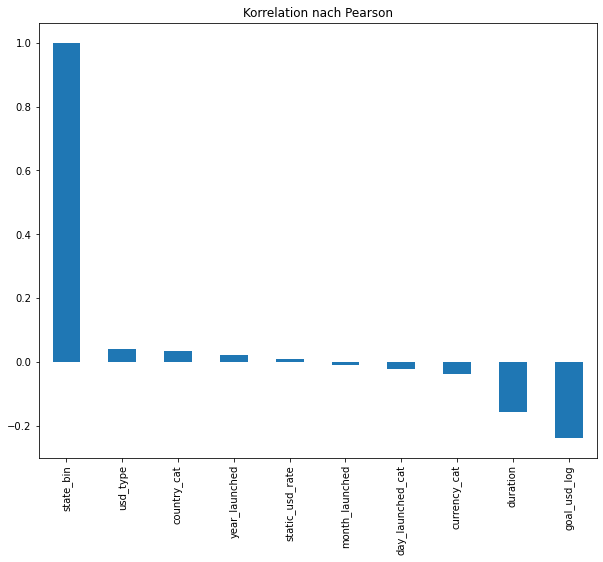

In [210]:
# correlation
basis=df_new.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

## Correlations with dummyvariables

In [211]:
# Einführung von Dummyvariablen für die Korrelationsanalyse
new_dummy= pd.get_dummies(df_new['maincategory_name'], prefix='new', drop_first=True)

In [212]:
new_dum = df_new.drop(['maincategory_name'], axis=1)

In [213]:
new_dum = pd.concat([new_dum,new_dummy], axis=1)

<AxesSubplot:title={'center':'Korrelation nach Pearson'}>

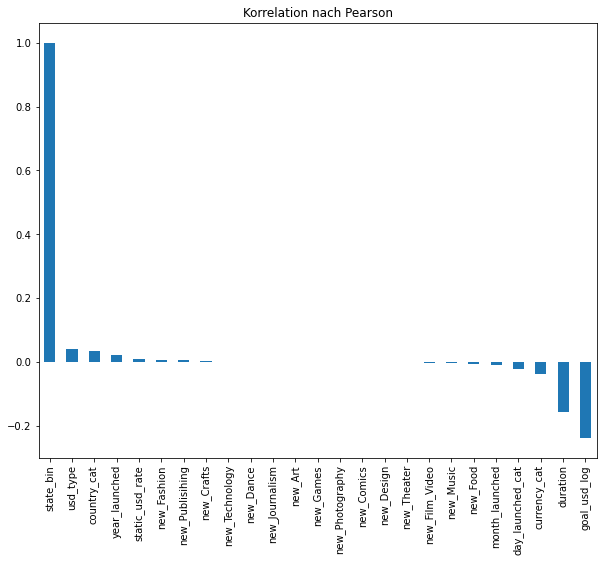

In [214]:
# correlation
corr=new_dum.corr(method='pearson')['state_bin'].sort_values(axis=0, ascending=False)
corr.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson')

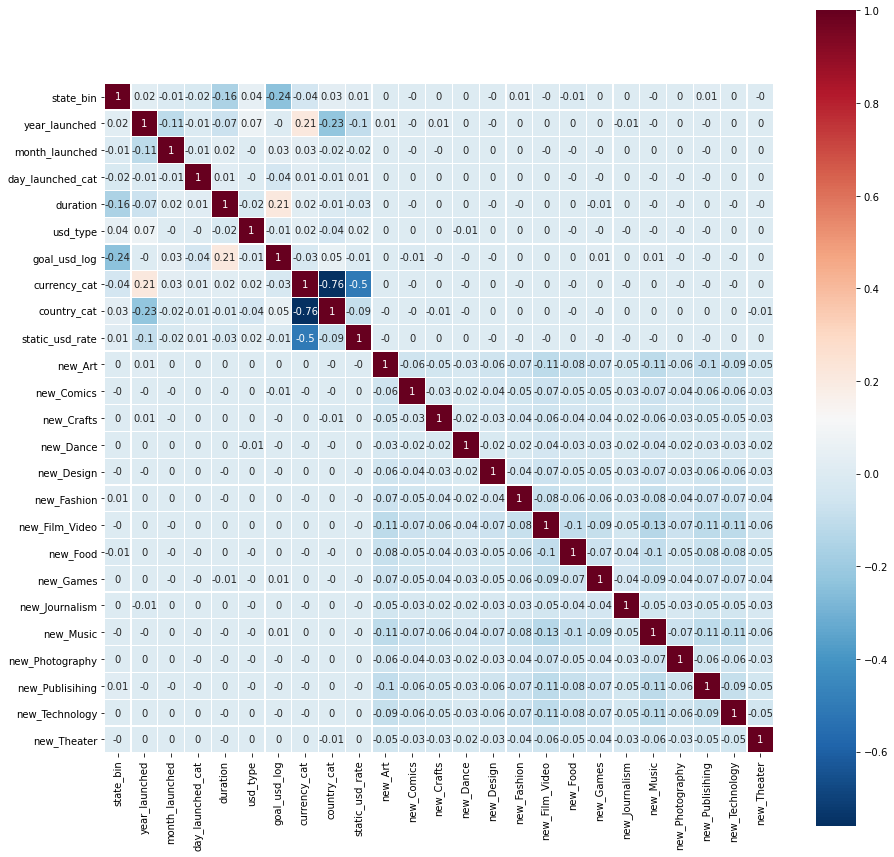

In [215]:
# heatmap - finding variables which are useful for prediction
plt.figure(figsize=(15,15))
sns.heatmap(data=new_dum.corr().round(2),annot=True,cmap='RdBu_r',linewidths=0.2,square=True);

# Modeling

In this section we will apply four different machine learning models for classification to the data. Our goal is to classify kickstarter projects into successesful or failed.

For each model we will evaluate the accuracy, precission and f1-score. The f1-score seems to be the most important and suitable measure, because there is no preference for false positives or false negatives (both are equally bad). 

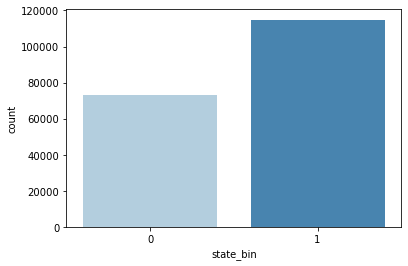

In [216]:
# countplot for our label
sns.countplot(x='state_bin',data=new_dum, palette='Blues');

In [220]:
# scaling and splitting the data into features and target label
X_unscaled = new_dum.drop(['state_bin'], axis=1)
scaler = StandardScaler()
X_new = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
y_new = new_dum['state_bin'].values

In [221]:
# Train Test Split 
from sklearn.model_selection import train_test_split

# Split the features and label data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.25, random_state = 0,stratify=y_new)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 140999 samples.
Testing set has 47000 samples.


In [222]:
data_test=np.array(y_test)
s = pd.Series(data_test)
s.value_counts()

1    28701
0    18299
dtype: int64

## Logistic Regression

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

### Feature Selection

We will start with different methods for feature selection. Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable.

In [224]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [225]:
len(new_dum.columns)

25

In [226]:
feature_name = list(df_new.columns)
# no of maximum features we need to select
num_feats=10

#### Pearson Correlation 

In [227]:
def cor_selector(X_new, y_new, num_feats):
    cor_list = []
    feature_name = X_new.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X_new.columns.tolist():
        cor = np.corrcoef(X_new[i], y_new)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X_new.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_new, y_new, num_feats)
print(str(len(cor_feature)), 'selected features')

cor_feature

10 selected features


['new_Fashion',
 'month_launched',
 'static_usd_rate',
 'day_launched_cat',
 'year_launched',
 'country_cat',
 'currency_cat',
 'usd_type',
 'duration',
 'goal_usd_log']

#### Chi Squared

In [228]:
#X_norm = StandardScaler().fit_transform(X)
#chi_selector = SelectKBest(chi2, k=num_feats)
#chi_selector.fit(X_norm, y)
#chi_support = chi_selector.get_support()
#chi_feature = X.loc[:,chi_support].columns.tolist()
#print(str(len(chi_feature)), 'selected features')

#chi_feature

#### Recursive Feature Elimination

In [229]:
X_new_norm = StandardScaler().fit_transform(X_new)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_new_norm, y_new)
rfe_support = rfe_selector.get_support()
rfe_feature = X_new.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

rfe_feature

Fitting estimator with 24 features.
Fitting estimator with 14 features.
10 selected features


['year_launched',
 'day_launched_cat',
 'duration',
 'usd_type',
 'goal_usd_log',
 'currency_cat',
 'country_cat',
 'static_usd_rate',
 'new_Fashion',
 'new_Publisihing']

#### Lasso SelectFromModel

In [230]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_new_norm, y_new)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_new.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

embeded_lr_feature

6 selected features


['year_launched',
 'day_launched_cat',
 'duration',
 'usd_type',
 'goal_usd_log',
 'country_cat']

#### Tree Based Selection

In [231]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X_new, y_new)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_new.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

embeded_rf_feature

6 selected features


['year_launched',
 'month_launched',
 'day_launched_cat',
 'duration',
 'goal_usd_log',
 'static_usd_rate']

#### All togeteher

In [232]:
# put all selection together
#feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support, 'Random Forest':embeded_rf_support})
# count the selected times for each feature
#feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
#feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
#feature_selection_df.index = range(1, len(feature_selection_df)+1)
#feature_selection_df.head(num_feats)

### Perform Logistic Regressoion

In [ ]:
# set X_new after feature selection


In [233]:
# train test split again with X_new
X_train,X_test,y_train,y_test = train_test_split(X_new,y_new,test_size=0.25,random_state=0)

In [234]:
# Step 1: Make an instance of the Model
log_reg = LogisticRegression(class_weight='balanced')

# Step 2: Train the model on the data
log_reg.fit(X_train, y_train)

# Step 3: predict the response for test data
y_pred = log_reg.predict(X_test)

In [235]:
print(log_reg.coef_.round(4))
print(log_reg.intercept_)

[[ 0.057   0.0066 -0.0599 -0.2288  0.0856 -0.4884 -0.0142  0.0988  0.0186
   0.0043 -0.0026  0.0033  0.0032  0.0041  0.0169  0.0023 -0.0032  0.0014
   0.0075  0.0045  0.004   0.0159  0.0069 -0.0085]]
[0.04038398]


In [236]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.6041702127659574
Precision Score : 0.7116635591464678
Recall Score : 0.595954338850144
F1 Score : 0.6486894780572552


In [237]:
# show calssification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.62      0.55     18179
           1       0.71      0.60      0.65     28821

    accuracy                           0.60     47000
   macro avg       0.60      0.61      0.60     47000
weighted avg       0.63      0.60      0.61     47000



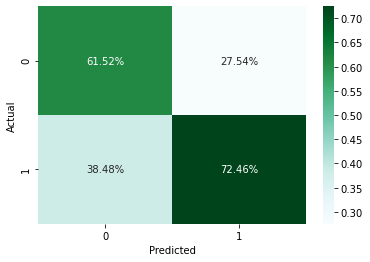

In [245]:
# confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%',cmap='BuGn');

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.607


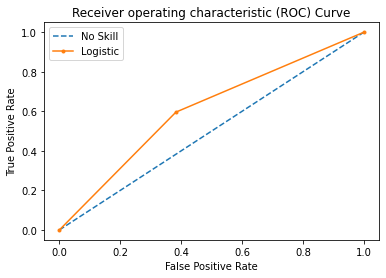

In [246]:
# take a look at TPR and TNR (AUC-ROC curve)
import matplotlib.pyplot as pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

no_skill_probs = [0 for _ in range(len(y_test))]

no_skill_auc = roc_auc_score(y_test, no_skill_probs)        
log_reg_auc = roc_auc_score(y_test, y_pred)

print('No Skill: ROC AUC=%.3f' % (no_skill_auc))        
print('Logistic: ROC AUC=%.3f' % (log_reg_auc))

no_skill_fpr, no_skill_tpr, _ = roc_curve(y_test, no_skill_probs)              
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, y_pred)

pyplot.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')       
pyplot.plot(log_reg_fpr, log_reg_tpr, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')        
pyplot.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')

pyplot.legend()     

pyplot.show()

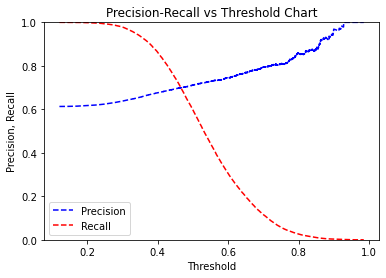

In [247]:
# check precision & recall 
from sklearn import metrics 

# Predict test_y values and probabilities based on fitted logistic 
y_probabilities=log_reg.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of 
  # array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);

In [248]:
# improve the model by setting the threshold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

THRESHOLD = 0.4

preds = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.662213
recall,0.861143
precision,0.676396
roc_auc_score,0.603986


The logistic regression model has a good accuracy score of around 0.9 (weighted average F1 score = 0.91). As we can see, the ROC-AUC curve is pulled towards the top left of the graph, which is a positive sign. In the following we try to improve oir logistic regression model.

### Parameter optimisation logistic regression

Our logistic regression model can potentially be further improved by optimising its parametersm using grid search.

In [249]:
# Grid search
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

Accuracy Score : 0.6636808510638298
Precision Score : 0.6725445481544337
Recall Score : 0.8800180423996391
F1 Score : 0.762418649392031


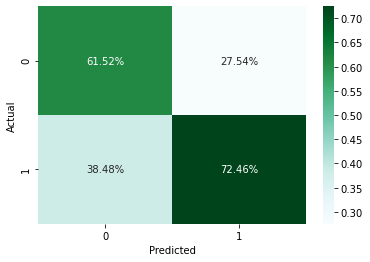

In [250]:
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,
            fmt='.2%',cmap='BuGn');

After hyperparameter tuning, the model's accuracy score could be improved from 0.604 up to 0.664. In this case our precision got wores from 0.711 down to 0.673 but the f1-score could be improved from 0.648 up to 0.762. 

**Before**
- Accuracy Score : 0.6041702127659574
- Precision Score : 0.7116635591464678
- Recall Score : 0.595954338850144
- F1 Score : 0.6486894780572552

**After**
- Accuracy Score : 0.6636808510638298
- Precision Score : 0.6725445481544337
- Recall Score : 0.8800180423996391
- F1 Score : 0.7624186493920311

## Random Forest

Random Forest is a robust machine learning algorithm that can be used for regression and classification. It is an ensemble method, meaning that a random forest model is made up of a large number of small decision trees, called estimators, which each produce their own predictions. The random forest model combines the predictions of the estimators to produce a more accurate prediction.

In [251]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [252]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 1)

# Step 2: Train the model on the data
forest.fit(X_train, y_train)

# Step 3: predict the response for test data
y_pred_rf = forest.predict(X_test)

In [270]:
n_nodes = []
max_depths = []

for ind_tree in forest.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 86060
Average maximum depth 47


In [254]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rf)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rf)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rf)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rf)))

Accuracy Score : 0.6887446808510639
Precision Score : 0.724628046850269
Recall Score : 0.7942472502689012
F1 Score : 0.757842114846634


In [255]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.62      0.52      0.56     18179
           1       0.72      0.79      0.76     28821

    accuracy                           0.69     47000
   macro avg       0.67      0.66      0.66     47000
weighted avg       0.68      0.69      0.68     47000



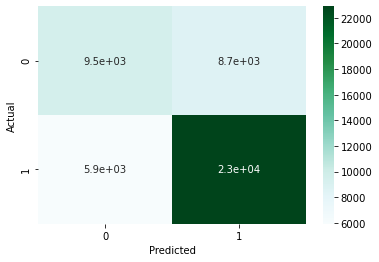

In [256]:
# confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='BuGn');

In [257]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

In [258]:
def evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, rf_predictions)
    results['precision'] = precision_score(y_test, rf_predictions)
    results['roc'] = roc_auc_score(y_test, rf_probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_rf_predictions)
    train_results['precision'] = precision_score(y_train, train_rf_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_rf_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, rf_probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.79 Train: 0.99
Precision Baseline: 0.61 Test: 0.72 Train: 0.99
Roc Baseline: 0.5 Test: 0.73 Train: 1.0


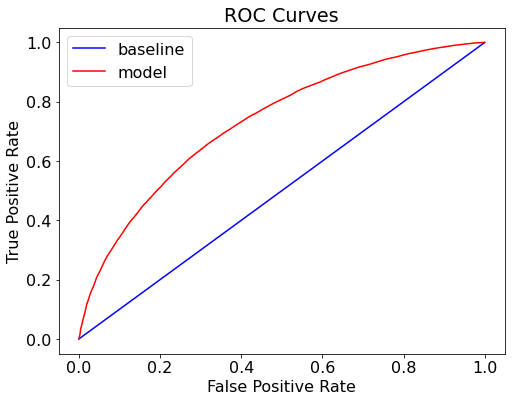

In [259]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

### Grid Search

In [260]:
# Step 1: set hyperparameter grid 
param_grid_rf = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Step 2: Make an instance of the Model
estimator = RandomForestClassifier(random_state = 1)

# Step 3: 
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid_rf, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=1)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                      

In [261]:
print("Best parameters:", rs.best_params_)

Best parameters: {'n_estimators': 106, 'min_samples_split': 2, 'max_leaf_nodes': 46, 'max_features': 0.8999999999999999, 'max_depth': 15, 'bootstrap': True}


In [262]:
best_model = rs.best_estimator_

In [263]:
train_rf_predictions_new = best_model.predict(X_train)
train_rf_probs_new = best_model.predict_proba(X_train)[:, 1]

rf_predictions_new = best_model.predict(X_test)
rf_probs_new = best_model.predict_proba(X_test)[:, 1]

In [264]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 91
Average maximum depth 10


Recall Baseline: 1.0 Test: 0.83 Train: 0.83
Precision Baseline: 0.61 Test: 0.72 Train: 0.71
Roc Baseline: 0.5 Test: 0.74 Train: 0.74


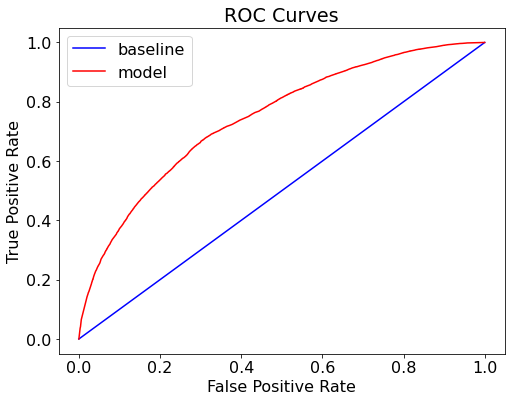

In [265]:
evaluate_model(rf_predictions_new, rf_probs_new, train_rf_predictions_new, train_rf_probs_new)

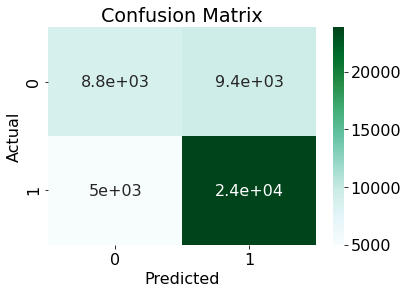

In [266]:
confusion_matrix = pd.crosstab(y_test, rf_predictions_new, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='BuGn').set_title('Confusion Matrix');

In [267]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predictions_new))

              precision    recall  f1-score   support

           0       0.64      0.48      0.55     18179
           1       0.72      0.83      0.77     28821

    accuracy                           0.69     47000
   macro avg       0.68      0.65      0.66     47000
weighted avg       0.69      0.69      0.68     47000



In [268]:
# Model Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test,rf_predictions_new)))
print('Precision Score : ' + str(precision_score(y_test,rf_predictions_new)))
print('Recall Score : ' + str(recall_score(y_test,rf_predictions_new)))
print('F1 Score : ' + str(f1_score(y_test,rf_predictions_new)))

Accuracy Score : 0.6933617021276596
Precision Score : 0.7165789869231926
Recall Score : 0.8270705388432046
F1 Score : 0.7678703733530908


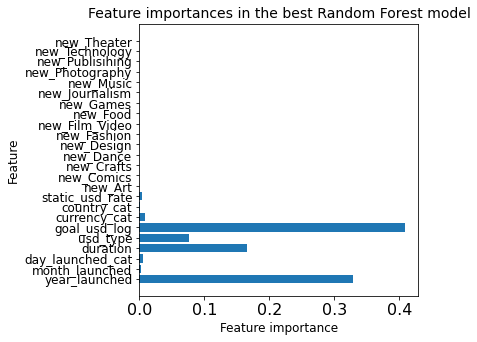

In [269]:
# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(5,5))
plt.barh(range(n_features), best_model.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values, fontsize=12) 
plt.title("Feature importances in the best Random Forest model", fontsize=14)
plt.xlabel("Feature importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()

### Results

After hyperparameter tuning, all values inspite of the precision score increase.

**Before**

- Accuracy Score : 0.6887446808510639
- Precision Score : 0.724628046850269
- Recall Score : 0.7942472502689012
- F1 Score : 0.757842114846634
- Average number of nodes 86060
- Average maximum depth 47

**After**
- Accuracy Score : 0.6933617021276596
- Precision Score : 0.7165789869231926
- Recall Score : 0.8270705388432046
- F1 Score : 0.7678703733530908

## SVN

In [271]:
# Define smaller Set for initial SVM Train / Test
df_2019=df_new.query('year_launched=="2019"')
df_2019.shape

(4560, 11)

In [272]:
# Setup of Dummyfeatures

dummy_2019=pd.get_dummies(df_2019['maincategory_name'], prefix='main', drop_first=True)
dum_2019 = df_2019.drop(['maincategory_name'], axis=1)
dum_2019 = pd.concat([dum_2019,dummy_2019], axis=1)

In [273]:
# Split the data into features and target label
y = dum_2019['state_bin'].values
X = dum_2019.copy()
X.drop(["state_bin"], axis = 1, inplace = True)

In [274]:
# scaling and splitting the data into features and target label
X_unscaled = dum_2019.drop(['state_bin'], axis=1)
scaler = StandardScaler()
X_2019 = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
y_2019 = dum_2019['state_bin'].values

In [275]:
# Train Test Split 
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 20,stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2736 samples.
Testing set has 1824 samples.


In [276]:
# Step 1: Import the model want to use 
from sklearn.svm import SVC

# Step 2: Make an instance of the Model
svc = SVC(kernel = "rbf", degree = 2)

# Step 3: Train the model on the data
svc.fit(X_train, y_train)

# Step 4: predict the response fpr test data
prediction = svc.predict(X_test)

In [277]:
print("Accuracy on training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.833
Accuracy on test set: 0.833


In [278]:
predictions = svc.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,prediction))
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       304
           1       0.83      1.00      0.91      1520

    accuracy                           0.83      1824
   macro avg       0.42      0.50      0.45      1824
weighted avg       0.69      0.83      0.76      1824

[[   0  304]
 [   0 1520]]


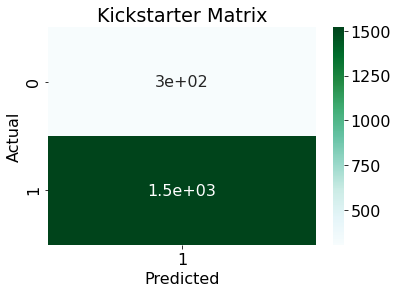

In [279]:
confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='BuGn').set_title('Kickstarter Matrix');

In [280]:
confusion_matrix

Predicted,1
Actual,
0,304
1,1520


In [ ]:
# import the necessary modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# add a standard scaler since SVC works better if the data is scaled.
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['poly','rbf']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
result = grid.fit(X_train, y_train)
result.best_params_

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier


from xgboost import XGBClassifier

In [ ]:
from vecstack import stacking


In [ ]:
models = [
    LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr'),
    
    ExtraTreesClassifier(random_state = 0, n_jobs = -1, 
            n_estimators = 100, max_depth = 3),
    
    KNeighborsClassifier(n_neighbors=7,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]

In [ ]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=1)

In [ ]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)
    
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

# Final model evaluation and interpretation

# Future work

Our future work will be to discuss the following items:
- **name**: name of the project
- **blurb**: short description of the project
- **profile**: contains a couple of profilerelated features
- **photo**: information about photos attached to the project
- **slug**: search engine text, contains a couple of features